In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int

from collections import namedtuple
from scipy.integrate import solve_ivp

In [24]:
# better plots
sns.set_style('whitegrid')

# config
EAT_RATE = 5 # g/min CHO

# required data structures
Action = namedtuple("patient_action", ['CHO', 'insulin'])

In [3]:
# read data
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

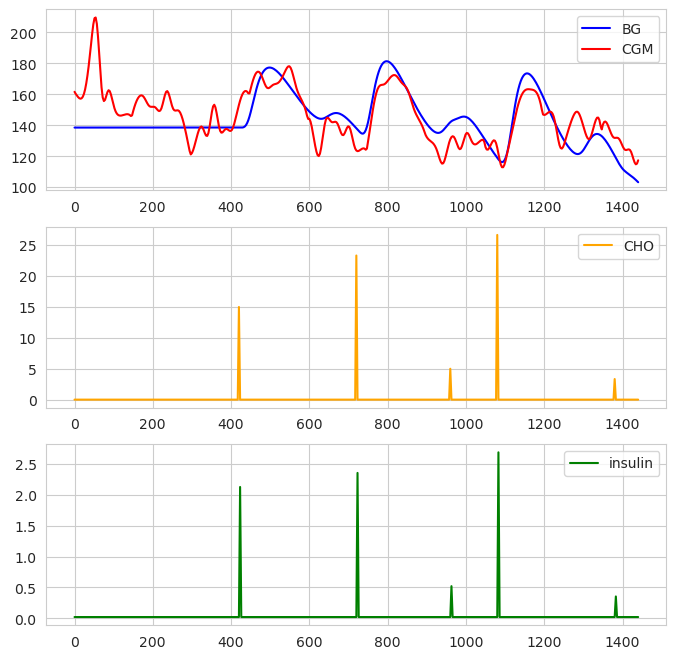

In [8]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
plt.plot(data_t, data_BG, "b", label="BG")
plt.plot(data_t, data_CGM, "r", label="CGM")
plt.legend()

plt.subplot(312)
plt.plot(data_t, data_CHO, "orange", label="CHO")
plt.legend()

plt.subplot(313)
plt.plot(data_t, data_insulin, "g", label="insulin")
plt.legend()

plt.show()

In [10]:

def ode(t, x, inputs, params):
    # desctructure inputs
    in_time, in_CHO, in_insulin = inputs

    # instantiate derivatives
    dxdt = np.zeros(13)

    # get current action
    t_mask = np.abs(in_time - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    d = action.CHO * 1000 # g -> mg
    insulin = action.insulin * 6000 / params.BW
    basal = in_insulin[0]

    # glucose in the stomach
    qsto = x[0] + x[1]

    last_foodtaken = 0
    if t_mask > 0:
        last_foodtaken = in_CHO[t_mask - 1]
    
    Dbar = last_foodtaken * 1000 # unit: mg

    # stomach solid
    dxdt[0] = -params.kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar))
            - np.tanh(cc * (qsto - params.d * Dbar))
            + 2
        )
    else:
        kgut = params.kmax

    # stomach liquid
    dxdt[1] = params.kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - params.kabs * x[2]

    # Rate of appearance
    Rat = params.f * params.kabs * x[2] / params.BW
    # Glucose Production
    EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = params.ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - params.k1 * x[3] + params.k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = (
        -(params.m2 + params.m4) * x[5]
        + params.m1 * x[9]
        + params.ka1 * x[10]
        + params.ka2 * x[11]
    )  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -params.ki * (x[7] - It)

    dxdt[8] = -params.ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = -params.ksc * x[12] + params.ksc * x[3]
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    return dxdt

In [11]:
# load parameters
orig_params = pd.read_csv("../simglucose/simglucose/params/vpatient_params.csv")
params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()

In [12]:
# timespan
t_span = (data_t[0], data_t[-1])
t_eval = data_t

In [13]:
# initial conditions
u0 = params.iloc[2:15].to_numpy()

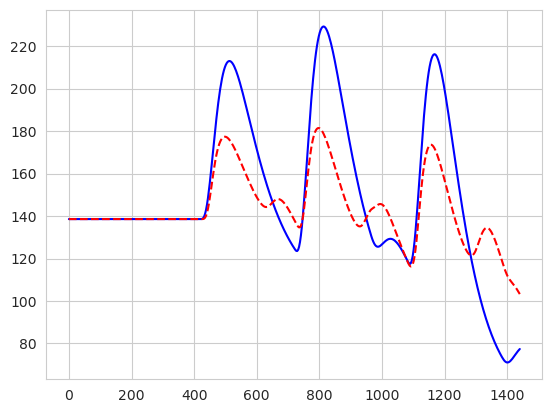

In [18]:
sol = solve_ivp(ode, t_span, u0, t_eval=t_eval, args=((data_t, data_CHO, data_insulin), params))
sol_BG = sol.y[12] / params.Vg

plt.plot(sol.t, sol_BG, "b", label="sim")
plt.plot(data_t, data_BG, "r--", label="act")
plt.show()

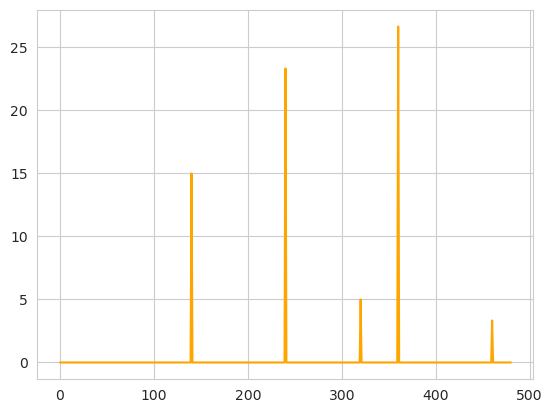

In [21]:
plt.plot(data_CHO, "orange")
plt.show()

In [25]:
data_t[data_CHO > data_CHO[0]]

array([ 420.,  720.,  960., 1080., 1380.])

In [36]:
data_t[data_insulin > data_insulin[0]]

array([ 423.,  723.,  963., 1083., 1383.])

In [30]:
data_CHO[data_t == 417]

array([0.])

In [23]:
data_t

array([   0.,    3.,    6.,    9.,   12.,   15.,   18.,   21.,   24.,
         27.,   30.,   33.,   36.,   39.,   42.,   45.,   48.,   51.,
         54.,   57.,   60.,   63.,   66.,   69.,   72.,   75.,   78.,
         81.,   84.,   87.,   90.,   93.,   96.,   99.,  102.,  105.,
        108.,  111.,  114.,  117.,  120.,  123.,  126.,  129.,  132.,
        135.,  138.,  141.,  144.,  147.,  150.,  153.,  156.,  159.,
        162.,  165.,  168.,  171.,  174.,  177.,  180.,  183.,  186.,
        189.,  192.,  195.,  198.,  201.,  204.,  207.,  210.,  213.,
        216.,  219.,  222.,  225.,  228.,  231.,  234.,  237.,  240.,
        243.,  246.,  249.,  252.,  255.,  258.,  261.,  264.,  267.,
        270.,  273.,  276.,  279.,  282.,  285.,  288.,  291.,  294.,
        297.,  300.,  303.,  306.,  309.,  312.,  315.,  318.,  321.,
        324.,  327.,  330.,  333.,  336.,  339.,  342.,  345.,  348.,
        351.,  354.,  357.,  360.,  363.,  366.,  369.,  372.,  375.,
        378.,  381.,

In [33]:
cont_time = np.arange(data_t[0], data_t[-1])

In [35]:
cont_time[-1]

1439.0